## Faithfulness experiment analysis

We have run an experiment by generating evaluations on a set of qa-pairs with lynx, vectara and g-eval using different models. This evaluation is a comparison of these approaches, trying to understand where they overlap, and what might be the issues if we were to shift from gpt-4 to gemini as our g-eval evaluator.

In [1]:
import psycopg2
import boto3
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from textwrap import wrap
from itertools import combinations
from matplotlib_venn import venn3, venn2
from dotenv import load_dotenv, find_dotenv
from sklearn.metrics import confusion_matrix, f1_score

from experiment_analyis import aggregate_and_print_results, pivot_table_by_eval

In [2]:
load_dotenv(find_dotenv())

True

In [3]:
# getting the secrets from the parameter store relating to the RDS database

session = boto3.Session()

ssm = session.client('ssm')

response = ssm.get_parameter(Name="/RAG/LABS_RDS_DB_CREDS", WithDecryption=True)

secret = response['Parameter']['Value']


In [4]:
conn = psycopg2.connect(**json.loads(secret))

In [5]:
# getting all the qa-pairs relating to the tag: g_eval_comparison_experiment

cur = conn.cursor()

cur.execute("""
    SELECT qa.id, qa.generation, qa.question, qa.answer, qa.evals, qa.model, qa.prompt, qa.updated_at, qa.generation, q.prompt
    FROM qapair qa
        JOIN dbquery q ON qa.query_id = q.id
    WHERE pipeline_id = 'g_eval_comparison_experiment_2' AND evals <> '{}'::jsonb;
""")


rows = cur.fetchall()

print(len(rows))

15403


In [6]:
df = pd.DataFrame(rows, columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "generation", "query-prompt"])

In [7]:
raw_evals = pd.DataFrame.from_dict(df[["id", "evals"]].set_index("id").to_dict()["evals"], orient="index")

print(raw_evals.shape)

# raw_evals = raw_evals[raw_evals["substring_match-system_response"].apply(lambda x: False if pd.isna(x) else json.loads(x).get("score") == 1)]
# raw_evals.drop(columns=["substring_match-system_response"], inplace=True)

evals = raw_evals.applymap(lambda x: x if pd.isna(x) else json.loads(x)["score"])

evals.shape

(15403, 9)


(15403, 9)

In [8]:
for c in evals.columns:
    print(c, evals[c].count())

vectara-faithfulness 10872
g_eval-faithfulness_gpt4o 11505
g_eval-faithfulness_gemini 15313
g_eval-faithfulness_llama3 14440
patronus_lynx-faithfulness 12121
g_eval-faithfulness 3645
rule_based-formatting 2494
g_eval-cpr-generation-policy 4112
substring_match-system_response 4259


vectara-faithfulness 8566<br>
g_eval-faithfulness_gpt4o 7150<br>
g_eval-faithfulness_gemini 15311<br>
g_eval-faithfulness_llama3 14440<br>
patronus_lynx-faithfulness 12121<br>
g_eval-faithfulness 3645<br>
rule_based-formatting 2494<br>
g_eval-cpr-generation-policy 4112<br>
substring_match-system_response 4259<br>

In [10]:
print(f"{raw_evals.dropna(subset=['vectara-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini', 'g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness']).shape[0]} items with all evaluators")
print(f"Evaluators used: {evals.columns.tolist()}")

7044 items with all evaluators
Evaluators used: ['vectara-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini', 'g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness', 'g_eval-faithfulness', 'rule_based-formatting', 'g_eval-cpr-generation-policy', 'substring_match-system_response']


~~I messed up on the prompting for g-eval, because that now outputs 5 for violation scaled to 1. For absolute clarity, spelling these out here:~~
- patronus: 1 is faithful, 0 is violation
- ~~g_eval: 1 is violation, 0 is faithful~~ this is only true for policy-violation, not faithfulness, so: 1 is faithful, 0 is violation
- vectara: 1 is faithful, 0 is violation

In [11]:
# turning everything into 1=violation, 0=faithful

transformation_functions = {
    'g_eval-faithfulness_gemini': lambda x: x <= 0.8,
    'g_eval-faithfulness_llama3': lambda x: x <= 0.8,
    'g_eval-faithfulness_gpt4o': lambda x: x <= 0.8,
    'patronus_lynx-faithfulness': lambda x: True if x == 0 else False,
    'vectara-faithfulness': lambda x: x <= 0.6,
}

evals = evals[transformation_functions.keys()]

In [12]:
for col in evals.columns:
    evals[col] = evals[col].apply(lambda x: None if pd.isna(x) else int(transformation_functions[col](x)))

In [13]:
global_violation_ratios = {}

for col in evals.columns:
    _tmp = evals[col].dropna()
    print("{:>30}:{:>7}  violations out of {:>6} ({:<6})".format(col, int(_tmp.sum()), int(_tmp.shape[0]), round(_tmp.sum() / _tmp.shape[0], 4)))
    global_violation_ratios[col] = _tmp.sum() / _tmp.shape[0]

    g_eval-faithfulness_gemini:   6688  violations out of  15313 (0.4368)
    g_eval-faithfulness_llama3:   3123  violations out of  14440 (0.2163)
     g_eval-faithfulness_gpt4o:   3513  violations out of  11505 (0.3053)
    patronus_lynx-faithfulness:   3122  violations out of  12121 (0.2576)
          vectara-faithfulness:   3312  violations out of  10872 (0.3046)


Okay, so after getting confused by the way to turn these into violations, this is looking a lot better. We're saying that:
- gemini flags the most violations (43.68%)
- llama3 flags the least (21.63%)

Everything else is in between, around the 25-30 percent mark, which seems managable from a user perspective. Now we need to understand the overlap of these.

In [14]:
_tmp = pd.DataFrame(evals.sum(axis=1).value_counts(normalize=True).sort_index())

_tmp.index = _tmp.index.astype(int)
_tmp.style.format("{:.3%}")


,0
0,28.157%
1,36.571%
2,19.659%
3,10.712%
4,4.259%
5,0.643%


Only 0.6% of all cases has an agreement of all 5 annotators, but >10% shows a three-way agreement, which seems pretty solid.

In [15]:
_tmp = pd.DataFrame(
    evals[
        ["g_eval-faithfulness_gemini",
         "patronus_lynx-faithfulness",
         "vectara-faithfulness"
        ]
    ].sum(axis=1).value_counts(normalize=True).sort_index()
)

_tmp.index = _tmp.index.astype(int)
_tmp.style.format("{:.3%}")

,0
0,33.007%
1,50.665%
2,14.458%
3,1.870%


Checking the case where we're using the 3 selected evaluators. It seems like only 33% of the cases would be free of any flags in this case.<br><br>
Comparing with the current setup with `gpt4o` below:

In [16]:
_tmp = pd.DataFrame(
    evals[
        ["g_eval-faithfulness_gpt4o",
         "patronus_lynx-faithfulness",
         "vectara-faithfulness"
        ]
    ].sum(axis=1).value_counts(normalize=True).sort_index()
)

_tmp.index = _tmp.index.astype(int)
_tmp.style.format("{:.3%}")

,0
0,48.679%
1,39.226%
2,10.933%
3,1.162%


The current setup leaves more examples unlabelled: `33% -> 48.7%`

In [17]:
def get_f1_score_and_count(_evals: pd.DataFrame, model1: str, model2: str) -> tuple[float, int]:
    _evals = _evals.dropna(subset=[model1, model2]).copy()
    y_true = _evals[model1]
    y_pred = _evals[model2]
    return f1_score(y_true, y_pred), y_true.shape[0]

In [18]:
df_f1s = pd.DataFrame(index=evals.columns, columns=evals.columns)
df_counts = pd.DataFrame(index=evals.columns, columns=evals.columns)

for model1, model2 in combinations(evals.columns, 2):
    df_f1s.loc[model1, model2], df_counts.loc[model1, model2] = get_f1_score_and_count(evals, model1, model2)

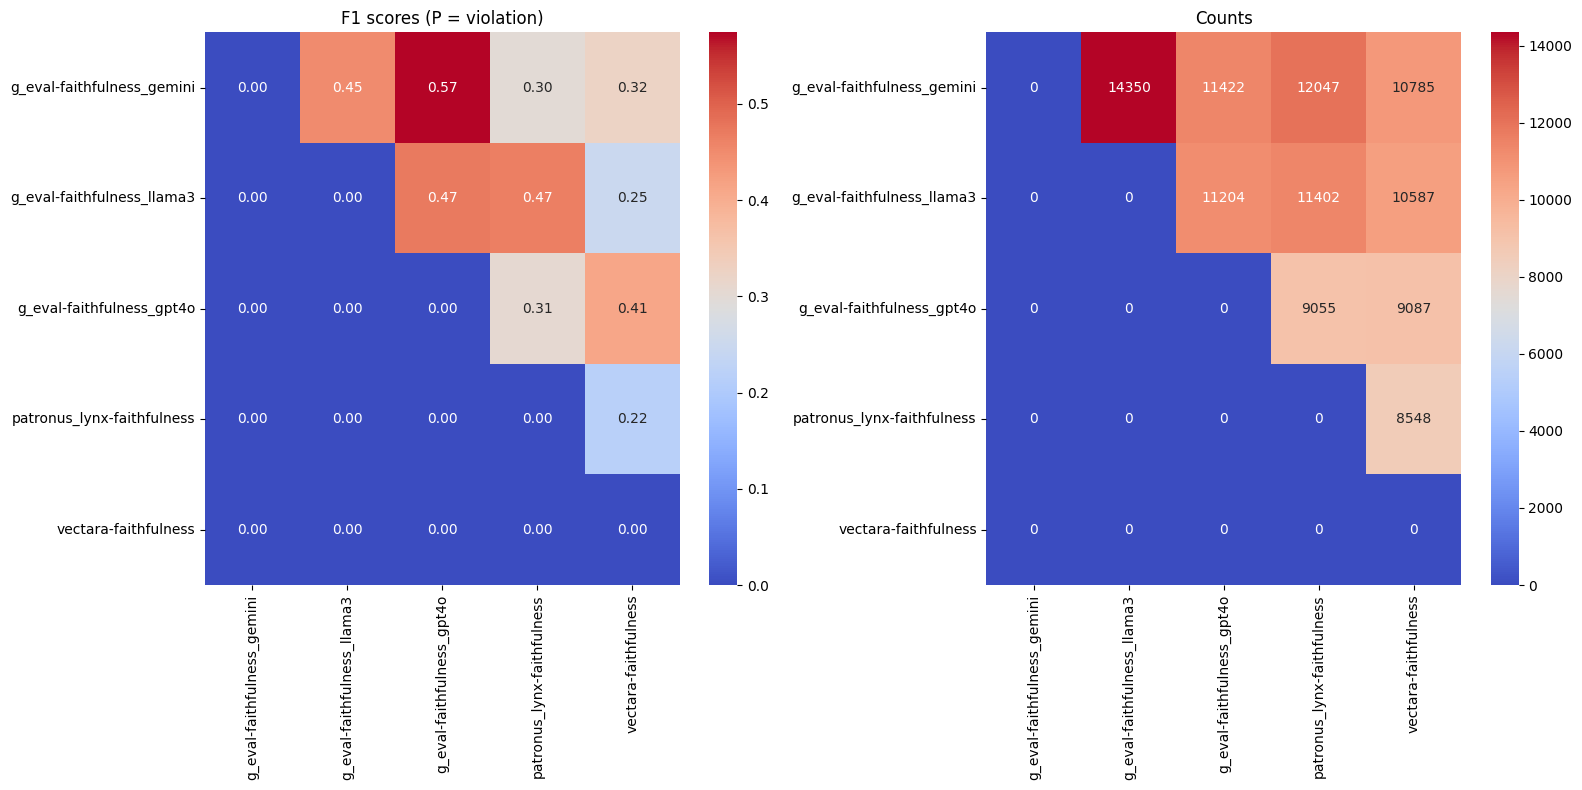

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

for _ax, title, _df, fmt in zip(ax, ["F1 scores (P = violation)", "Counts"], [df_f1s, df_counts], [".2f", ".0f"]):
    sns.heatmap(_df.fillna(0).astype(float), annot=True, cmap="coolwarm", ax=_ax, fmt=fmt)
    _ax.set_title(title)

plt.tight_layout()

So what we're seeing is:
- the highest agreement is between `gpt4o` and `gemini` -- this are models "in the same league", so some agreement is expected, yet there still is a significant mismatch, that we'll dig into below
- the lowest agreement is between `patronus` and `vectara` -- this is fine, because we'll want to keep both of these in, and it feels like they're covering different subspaces
- vectara is quite different from everything, it's `gpt4o` that has the highest agreement with it -- this is unsurprising, this is the only NLU model

In [20]:
def _get_violation_ratio_scores(_evals: pd.DataFrame, global_violation_ratios: dict[str, float]) -> dict:
    violation_ratios = (_evals.sum(axis=0) / _evals.shape[0]).to_dict()
    return {k: violation_ratios[k] / global_violation_ratios[k] for k in violation_ratios}


def draw_venn_with_violation_ratios(models: list[str], evals: pd.DataFrame, global_violation_ratios: dict[str, float]):
    """Draws a venn diagram of 2 or 3 model comparisons, and prints the violation ratios of the models"""
    venn = None
    if len(models) == 2:
        venn = venn2
    elif len(models) == 3:
        venn = venn3
    else:
        raise ValueError("Only 2 or 3 models are supported")

    _evals = evals[models].dropna(subset=models)

    print(_get_violation_ratio_scores(_evals, global_violation_ratios))

    venn(
        [set(i for i, x in enumerate(_evals[col].tolist()) if x == 1) for col in models],
        set_labels=models
    )

    plt.show()

I have noticed, that there is some biased sampling going on when picking those subsamples, which all models have a score for. Hence, I'm including the violation ratios checked against those of the dataset. If we're seeing these numbers diverge from 1, that suggests, that the sample is biased, and might not be representative.

{'g_eval-faithfulness_llama3': 0.9695716633521815, 'g_eval-faithfulness_gemini': 1.202561743074979, 'g_eval-faithfulness_gpt4o': 1.0068475862630848}


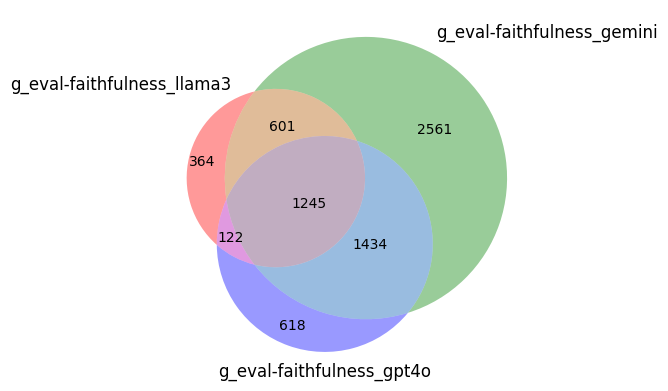

In [21]:
draw_venn_with_violation_ratios(
    models=['g_eval-faithfulness_llama3', 'g_eval-faithfulness_gemini', "g_eval-faithfulness_gpt4o"],
    evals=evals,
    global_violation_ratios=global_violation_ratios
)

This shows a decent agreement of the LLM-based evaluators
- 395 out of 2130 (18.5%) of the gpt flags are not covered by either llama or `gemini`
- 49% of all flags by these models are only flagged by 1 model. Majority of these is `gemini`

{'vectara-faithfulness': 0.8303111935038477, 'g_eval-faithfulness_gpt4o': 1.0774774308350843, 'g_eval-faithfulness_gemini': 1.2815890051236443}


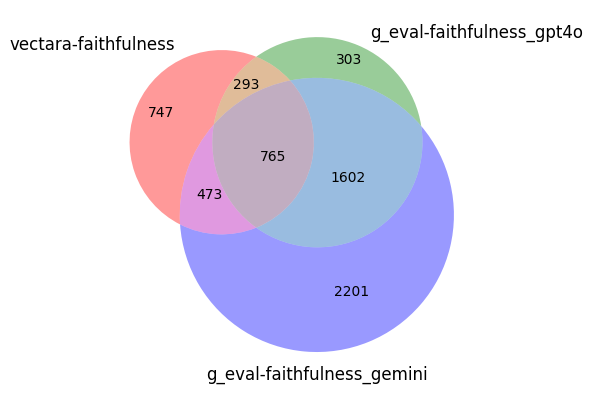

In [22]:
draw_venn_with_violation_ratios(['vectara-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini'], evals, global_violation_ratios)

In [23]:
gpt4o_flags = evals[evals["g_eval-faithfulness_gpt4o"] == 1]

uncovered = gpt4o_flags[
    (gpt4o_flags["g_eval-faithfulness_gemini"] == 0) & \
    (gpt4o_flags["vectara-faithfulness"] == 0) & \
    (gpt4o_flags["patronus_lynx-faithfulness"] == 0)
].shape[0]

print(f"Uncovered by other models: {uncovered} ({uncovered / gpt4o_flags.shape[0]:.2%})")

Uncovered by other models: 197 (5.61%)


Less than 5% of the g-eval flags would be "lost" if we go ahead not using it, but using gemini instead. This is okay, especially considering the extra flags gemini brings in.

In [24]:
gpt4o_flags = evals[evals["g_eval-faithfulness_gpt4o"] == 1]

uncovered = gpt4o_flags[
    (gpt4o_flags["g_eval-faithfulness_gemini"] == 0) & \
    (gpt4o_flags["g_eval-faithfulness_llama3"] == 0) & \
    (gpt4o_flags["vectara-faithfulness"] == 0) & \
    (gpt4o_flags["patronus_lynx-faithfulness"] == 0)
].shape[0]

print(f"Uncovered by other models: {uncovered} ({uncovered / gpt4o_flags.shape[0]:.2%})")

Uncovered by other models: 166 (4.73%)


Adding `llama3` to the mix doesn't change much, it only removes 10 of these, so the additional gain isn't that large.

In [25]:
gpt4o_flags = evals[evals["g_eval-faithfulness_gpt4o"] == 1]

uncovered = gpt4o_flags[
    (gpt4o_flags["g_eval-faithfulness_llama3"] == 0) & \
    (gpt4o_flags["vectara-faithfulness"] == 0) & \
    (gpt4o_flags["patronus_lynx-faithfulness"] == 0)
].shape[0]

print(f"Uncovered by other models: {uncovered} ({uncovered / gpt4o_flags.shape[0]:.2%})")

Uncovered by other models: 750 (21.35%)


On the other hand, were we to go with `llama3` instead of `gemini`, 20% of the gpt flags would be lost. This is to reiterate that `gemini` is a lot more similar to `gpt4o` in terms of what it picks up

{'g_eval-faithfulness_gemini': 1.191117237656868, 'g_eval-faithfulness_gpt4o': 0.9914967758895182}


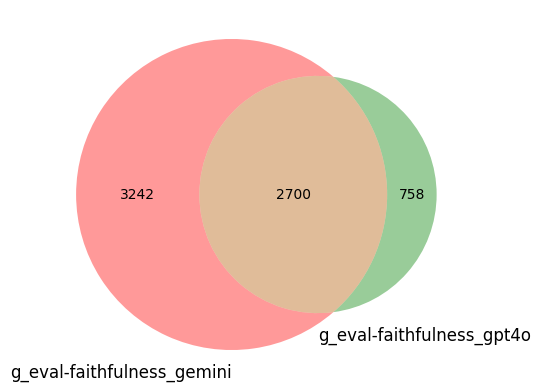

In [26]:
draw_venn_with_violation_ratios(['g_eval-faithfulness_gemini', 'g_eval-faithfulness_gpt4o'], evals, global_violation_ratios)


{'g_eval-faithfulness_llama3': 0.9915007242944552, 'patronus_lynx-faithfulness': 0.8924657058602955}


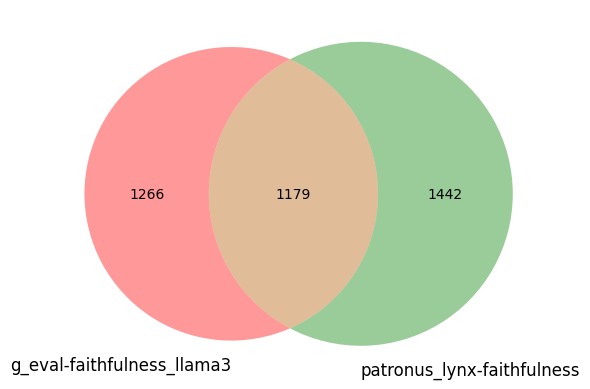

In [110]:
draw_venn_with_violation_ratios(['g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness'], evals, global_violation_ratios)


Even though these two are from the same family, there's a considerable difference between them.

{'g_eval-faithfulness_gemini': 1.0071674112120874, 'g_eval-faithfulness_llama3': 0.9934878095992735, 'patronus_lynx-faithfulness': 0.8910983923097247}


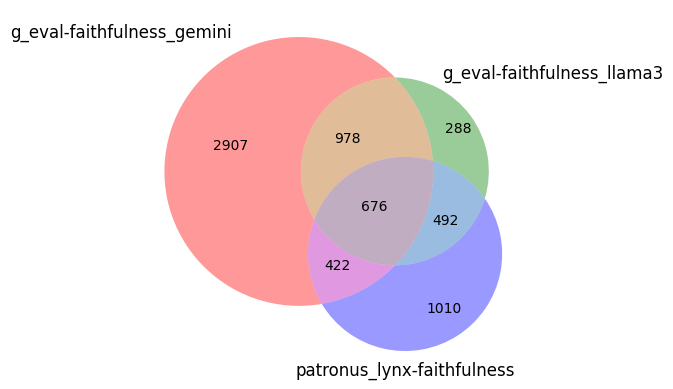

In [27]:
draw_venn_with_violation_ratios(['g_eval-faithfulness_gemini', 'g_eval-faithfulness_llama3', 'patronus_lynx-faithfulness'], evals, global_violation_ratios)


This paints a different picture though: `llama3` is almost fully subsumed by the mix of `gemini` and `patronus`

In [28]:
evals.value_counts(normalize=True)

g_eval-faithfulness_gemini  g_eval-faithfulness_llama3  g_eval-faithfulness_gpt4o  patronus_lynx-faithfulness  vectara-faithfulness
0.0                         0.0                         0.0                        0.0                         0.0                     0.263203
1.0                         0.0                         0.0                        0.0                         0.0                     0.192788
                                                        1.0                        0.0                         0.0                     0.082907
0.0                         0.0                         0.0                        0.0                         1.0                     0.071550
1.0                         1.0                         1.0                        0.0                         0.0                     0.050539
                            0.0                         1.0                        0.0                         1.0                     0.036343
    

In [29]:
# checking violation ratio scores for this subsample:

_get_violation_ratio_scores(evals.dropna(), global_violation_ratios)

{'g_eval-faithfulness_gemini': 1.2771052775921141,
 'g_eval-faithfulness_llama3': 0.9380113437279018,
 'g_eval-faithfulness_gpt4o': 1.0735272152933057,
 'patronus_lynx-faithfulness': 0.4999119199860599,
 'vectara-faithfulness': 0.8127299212404019}

This shows, that the above numbers are mostly unreliable, in particular those relating to gemini, the flags of which are overrepresented at 220% of the global distribution.

{'patronus_lynx-faithfulness': 0.6777436111697938, 'g_eval-faithfulness_gpt4o': 0.989270920863457, 'g_eval-faithfulness_gemini': 1.1893914939483372}


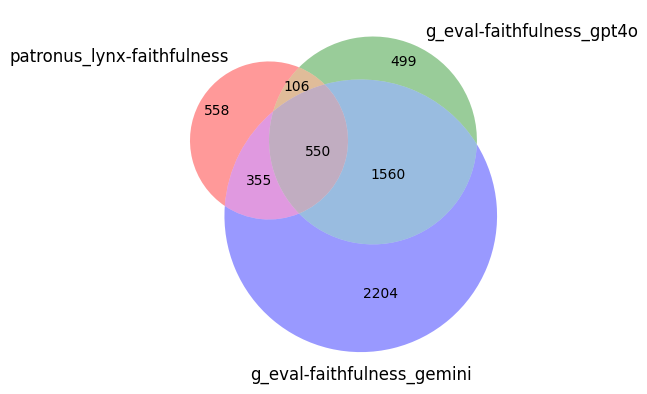

In [30]:
draw_venn_with_violation_ratios(['patronus_lynx-faithfulness', 'g_eval-faithfulness_gpt4o', 'g_eval-faithfulness_gemini'], evals, global_violation_ratios)


<Axes: ylabel='query-prompt'>

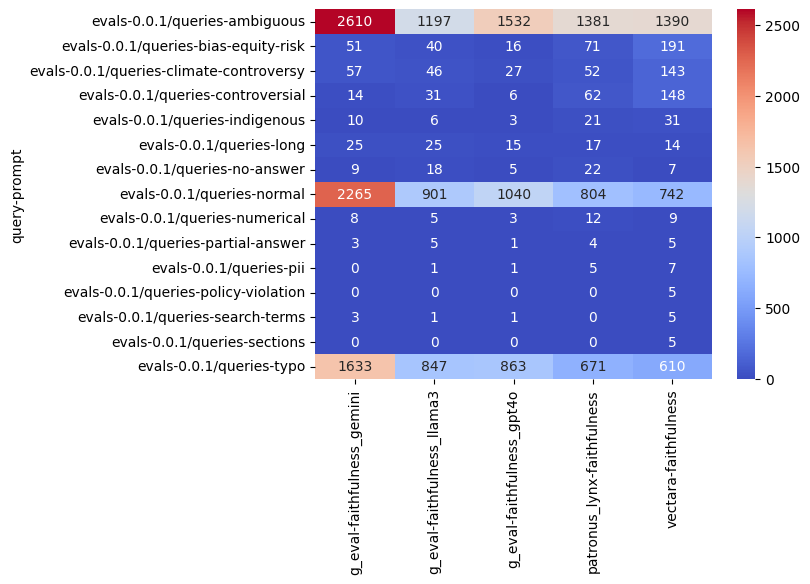

In [31]:
_tmp_df = evals.merge(df, left_index=True, right_on="id")[["query-prompt"] + list(evals.columns)]

sns.heatmap(_tmp_df.groupby("query-prompt").sum(), annot=True, cmap="coolwarm", fmt=".0f")

<Axes: ylabel='model'>

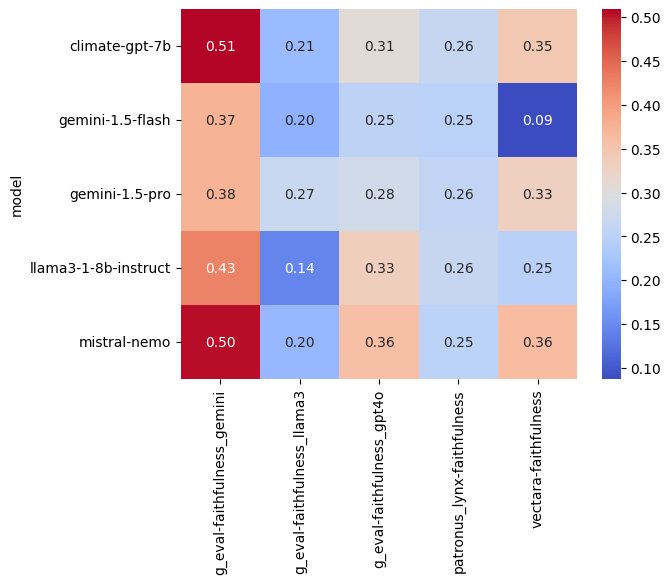

In [32]:
_tmp_df = evals.merge(df, left_index=True, right_on="id")[["model"] + list(evals.columns)]

sns.heatmap(_tmp_df.groupby("model").mean(), annot=True, cmap="coolwarm", fmt=".2f")

This is an interesting on:
- gemini prefers gemini, that's clear
- llama prefers llama
- patronus thinks they're all doing decently at the same level
- gpt4o brings gemini-flash out as winner, just like vectara by a long distance

In [33]:
df["query-prompt"].value_counts()

evals-0.0.1/queries-ambiguous              5991
evals-0.0.1/queries-normal                 4558
evals-0.0.1/queries-typo                   3649
evals-0.0.1/queries-bias-equity-risk        395
evals-0.0.1/queries-climate-controversy     330
evals-0.0.1/queries-controversial           230
evals-0.0.1/queries-indigenous               80
evals-0.0.1/queries-long                     50
evals-0.0.1/queries-no-answer                45
evals-0.0.1/queries-numerical                30
evals-0.0.1/queries-partial-answer           15
evals-0.0.1/queries-pii                      10
evals-0.0.1/queries-search-terms             10
evals-0.0.1/queries-policy-violation          5
evals-0.0.1/queries-sections                  5
Name: query-prompt, dtype: int64

In [34]:
df["model"].value_counts()

gemini-1.5-pro          4715
climate-gpt-7b          3319
mistral-nemo            3249
gemini-1.5-flash        2247
llama3-1-8b-instruct    1873
Name: model, dtype: int64

At this point we realised, that the distribution is not what we wanted from this experiment, so this has to be mitigated. 

## Sampling and inspecting data
After the largely confusing and unclear results above, we need to look at the data, and maybe that gives us some signposts as to the behaviour differences of the models. 

In [68]:
_tmp_df = evals[evals["patronus_lynx-faithfulness"] == 1].merge(df, left_index=True, right_on="id")[["question", "answer", "model", "answer-prompt", "query-prompt", "generation"]]

_tmp_df["sources"] = _tmp_df["generation"].apply(lambda x: [i["page_content"] for i in json.loads(x)["rag_response"]["retrieved_documents"]])

In [69]:
def wrapped(x: str):
    return "\n".join(wrap(x.replace("\n", "NNNNN"), 100)).replace("NNNNN", "\n")

def format_row(row: pd.Series):
    question = wrapped(row["question"])
    answer = wrapped(row["answer"])
    model = wrapped(row["model"])
    sources = wrapped("\n\t".join([f"[{i}]: {t}" for i, t in enumerate(row["sources"])]))

    return "=" * 50 + f"\nQuestion ({row['query-prompt']}):\n{question}\n\nAnswer:\n{answer}\n\nModel:\n{model}\n\nSources:\n{sources}"

In [74]:
print(
    format_row(
        _tmp_df.sample(1).iloc[0]
    )
)

Question (evals-0.0.1/queries-ambiguous):
Economic implications

Answer:
 - Economic implications of climate change include: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
192, 193, 194, 195, 196, 19

## New experiment
We need a SQL query that selects a good distribution of items.

In [85]:
conn = psycopg2.connect(**json.loads(secret))

Using partition to make sure we get representative splits of answer-prompt, question-prompt and model:

In [160]:

cur = conn.cursor()

cur.execute("""
    SELECT * 
    FROM (
            SELECT 
                qa.id,
                qa.generation,
                qa.question,
                qa.answer,
                qa.evals,
                qa.model,
                qa.prompt,
                qa.updated_at,
                qa.generation,
                q.prompt,
                ROW_NUMBER() OVER(PARTITION BY qa.model, qa.prompt, q.prompt) AS rn
            FROM qapair qa
                JOIN dbquery q ON qa.query_id = q.id
            WHERE pipeline_id = 'main_answer_run_2024_08_10' 
                AND qa.model NOT IN ('neural-chat-7b')
                AND qa.prompt NOT IN ('evals-answers-0.0.1/explain_assumptions', 'evals-answers-0.0.1/branch', 'evals-answers-0.0.1/kg_intermediate')
                AND q.prompt NOT IN ('evals-0.0.1/queries-harmful', 'evals-0.0.1/queries-inference', 'evals-0.0.1/queries-esl', 'evals-0.0.1/queries-complex', 'evals-0.0.1/queries-bias', 'evals-0.0.1/queries-factual-errors', 'evals-0.0.1/queries-opinions', 'evals-0.0.1/queries-jailbreak', 'evals-0.0.1/queries-nonsense')
        ) a
    WHERE rn < 750;
""")


rows = cur.fetchall()

print(len(rows))

15406


In [161]:
_df = pd.DataFrame(
    rows,
    columns=["id", "generation-json", "question", "answer", "evals", "model", "answer-prompt", "updated-at", "generation", "query-prompt", "row-number"]
)


_df["query-prompt"].value_counts()

evals-0.0.1/queries-ambiguous              5994
evals-0.0.1/queries-normal                 4558
evals-0.0.1/queries-typo                   3649
evals-0.0.1/queries-bias-equity-risk        395
evals-0.0.1/queries-climate-controversy     330
evals-0.0.1/queries-controversial           230
evals-0.0.1/queries-indigenous               80
evals-0.0.1/queries-long                     50
evals-0.0.1/queries-no-answer                45
evals-0.0.1/queries-numerical                30
evals-0.0.1/queries-partial-answer           15
evals-0.0.1/queries-pii                      10
evals-0.0.1/queries-search-terms             10
evals-0.0.1/queries-policy-violation          5
evals-0.0.1/queries-sections                  5
Name: query-prompt, dtype: int64

In [162]:
_df["model"].value_counts()

gemini-1.5-pro          4715
climate-gpt-7b          3322
mistral-nemo            3249
gemini-1.5-flash        2247
llama3-1-8b-instruct    1873
Name: model, dtype: int64

In [163]:
_df["answer-prompt"].value_counts()

evals-answers-0.0.1/basic_answer            10011
evals-answers-0.0.1/chain_of_thought         5388
evals-answers-0.0.1/basic_answer_refined        7
Name: answer-prompt, dtype: int64